In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
#for notebook Jupyter
%matplotlib inline 
import matplotlib.pyplot as plt
import joypy
#data preprocessing
from sklearn.preprocessing import StandardScaler
from scipy import stats
from itertools import combinations
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm

#print("python:", sys.executable)
#print("pandas:", pd.__version__)
#avoid the warnings
import warnings
warnings.filterwarnings('ignore')


## Loading Data

In [2]:
#my directory of the data- change to your directory of ddata
DATA_DIR = Path(r"C:\Users\Owner\Documents\datsci\rents")#change to where the csv files are, this is where we will read the data

#where the outputs are  gonna be
OUT_DIR  = Path(r"C:\Users\Owner\Documents\GitHub\DAT490\data") #change to where you want the data to go
OUT_DIR.mkdir(parents=True, exist_ok=True)
METRO_FILES = {
    "phoenix":     DATA_DIR / "final_zcta_dataset_phoenix.csv",
    "memphis":     DATA_DIR / "final_zcta_dataset_memphis.csv",
    "los_angeles": DATA_DIR / "final_zcta_dataset_los_angeles.csv",
    "dallas":      DATA_DIR / "final_zcta_dataset_dallas.csv",
}
#new directory for names
METRO_NAMES = {
    "phoenix": "Phoenix-Mesa-Chandler, AZ",
    "memphis": "Memphis, TN-MS-AR",
    "los_angeles": "Los Angeles-Long Beach-Anaheim, CA",
    "dallas": "Dallas-Fort Worth-Arlington, TX"
}


#keep this for spatial analysis
METRO_CONFIGS = {
    "phoenix": {
        "name": "Phoenix-Mesa-Chandler, AZ",
        "cbsa_code": "38060",
        "state_fips": "04",
        "county_fips_list": ["013", "021"],
        "zip_prefixes": ["85"],
        "utm_zone": 32612
    },
    "memphis": {
        "name": "Memphis, TN-MS-AR",
        "cbsa_code": "32820",
        "state_fips": "47",
        "county_fips_list": ["157", "047", "033"],
        "zip_prefixes": ["38", "72"],
        "utm_zone": 32616
    },
    "los_angeles": {
        "name": "Los Angeles-Long Beach-Anaheim, CA",
        "cbsa_code": "31080",
        "state_fips": "06",
        "county_fips_list": ["037"],
        "zip_prefixes": ["90", "91"],
        "utm_zone": 32611
    },
    "dallas": { #keeping dfw as it is to simplify things, just added collin fipscode
        #ping me for more cbsa codes if desired.. i was able to find them
        "name": "Dallas-Fort Worth-Arlington, TX",
        "cbsa_code": "19100",
        "state_fips": "48",
        "county_fips_list": ["113", "085", "121", "257", "439"],
        "zip_prefixes": ["75", "76"],
        "utm_zone": 32614
    }
}


In [3]:
def light_clean(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # date time formatting
    if "period" in df.columns:
        df["period"] = pd.to_datetime(df["period"], errors="coerce")

    # income_segment is encoded as "Low", "Medium" and "High"; we will make sure it is categorical
    if "income_segment" in df.columns:
        # Convert to ordered categorical
        df["income_segment"] = pd.Categorical(
            df["income_segment"],
            categories=["Low", "Medium", "High"],
            ordered=True
        )

    # enforce numeric type where it needs to be just in case
    for col in [
        "rent_to_income", "pct_rent_burden_30", "pct_rent_burden_50", "zori", "commute_min_proxy",
        "pct_commute_lt10", "pct_commute_10_19", "pct_commute_20_29", "pct_commute_30_44",
        "pct_commute_45_59", "pct_commute_60_plus", "ttw_total", "pct_drive_alone", "pct_carpool",
        "pct_car", "pct_transit", "pct_walk", "pct_wfh", "total_pop", "pct_white", "pct_black",
        "pct_asian", "pct_hispanic", "pct_other", "median_income", "stops_per_km2"
    ]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    return df

In [4]:
#this is our join. We will be keeping the above directory untouched for now
frames = []

for key, path in METRO_FILES.items():
    print(f"Loading {METRO_NAMES[key]} from {path}...")
    
    temp = pd.read_csv(path, low_memory=False)
    temp = light_clean(temp)
    
    # Tag the metro identity
    temp["metro_key"]  = key
    temp["metro_name"] = METRO_NAMES[key]
    
    frames.append(temp)

df = pd.concat(frames, ignore_index=True)
# Split combined df into metro-specific dataframes
phoenix_df     = df[df["metro_key"] == "phoenix"].copy()
memphis_df     = df[df["metro_key"] == "memphis"].copy()
los_angeles_df = df[df["metro_key"] == "los_angeles"].copy()
dallas_df      = df[df["metro_key"] == "dallas"].copy()

print(f"Phoenix ZCTAs: {len(phoenix_df)}")
print(f"Memphis ZCTAs: {len(memphis_df)}")
print(f"Los Angeles ZCTAs: {len(los_angeles_df)}")
print(f"Dallas ZCTAs: {len(dallas_df)}")


df.shape, df.head()

Loading Phoenix-Mesa-Chandler, AZ from C:\Users\Owner\Documents\datsci\rents\final_zcta_dataset_phoenix.csv...
Loading Memphis, TN-MS-AR from C:\Users\Owner\Documents\datsci\rents\final_zcta_dataset_memphis.csv...
Loading Los Angeles-Long Beach-Anaheim, CA from C:\Users\Owner\Documents\datsci\rents\final_zcta_dataset_los_angeles.csv...
Loading Dallas-Fort Worth-Arlington, TX from C:\Users\Owner\Documents\datsci\rents\final_zcta_dataset_dallas.csv...
Phoenix ZCTAs: 150
Memphis ZCTAs: 60
Los Angeles ZCTAs: 270
Dallas ZCTAs: 190


((670, 31),
    ZCTA5CE  rent_to_income  pct_rent_burden_30  pct_rent_burden_50  \
 0    85003        0.371199           53.103617           10.291375   
 1    85004        0.365427           46.098395            8.466977   
 2    85006        0.243321           47.307833            7.905786   
 3    85007        0.261612           46.842588            7.926962   
 4    85008        0.247838           33.522505            2.522608   
 
           zori  commute_min_proxy  pct_commute_lt10  pct_commute_10_19  \
 0  1781.142157          21.953953         12.433286          41.114363   
 1  1824.106878          22.417636         14.027317          25.016263   
 2  1438.695628          24.451310          9.770753          25.927541   
 3  1450.002646          24.528932         12.625435          27.990609   
 4  1457.858483          25.473128          7.677261          35.097420   
 
    pct_commute_20_29  pct_commute_30_44  ...  pct_black  pct_asian  \
 0          27.529004          14.044

## Structuring Data for Segmentation

#### Demographic Categorization:

We begin by segmenting ZCTAs by majority race, in an effort to reduce noise in the dataset that would contribute to OLS models. The threshold magnitude we adopt is 50%- so any race that has more than 50% share in the ZCTA will become categorized as the majority race for the ZCTA.

In [5]:
def categorize_demographics_majority(df):
    """
    Adds 'demographic_category' based on 50% majority:
    Majority White / Majority Black / Majority Hispanic / Diverse.
    Assumes pct_* are in 0–100 scale.
    """
    df = df.copy()
    
    # ensure numeric
    for col in ["pct_white", "pct_black", "pct_hispanic"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # assume 0–100 percentages -> 50% threshold
    threshold = 50.0

    conditions = [
        df["pct_white"]   > threshold,
        df["pct_black"]   > threshold,
        df["pct_hispanic"]> threshold
    ]
    choices = ["Majority White", "Majority Black", "Majority Hispanic"]

    df["demographic_category"] = np.select(
        conditions, choices, default="Diverse"
    )
    return df


In [6]:
phoenix_df     = categorize_demographics_majority(phoenix_df)
memphis_df     = categorize_demographics_majority(memphis_df)
los_angeles_df = categorize_demographics_majority(los_angeles_df)
dallas_df      = categorize_demographics_majority(dallas_df)

print("Dallas demographic distribution:")
print(dallas_df["demographic_category"].value_counts())
print("\nLos Angeles demographic distribution:")
print(los_angeles_df["demographic_category"].value_counts())


Dallas demographic distribution:
demographic_category
Diverse              77
Majority White       70
Majority Hispanic    33
Majority Black       10
Name: count, dtype: int64

Los Angeles demographic distribution:
demographic_category
Diverse              99
Majority Hispanic    92
Majority White       73
Majority Black        6
Name: count, dtype: int64


In [7]:

def plot_demographic_pie(df, metro_name):
    """
    Pie chart for demographic_category distribution in one metro.
    """
    counts = df["demographic_category"].value_counts()
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=counts.index, autopct="%1.1f%%",
            startangle=140, wedgeprops=dict(edgecolor="white"))
    
    plt.title(f"{metro_name} Demographic Distribution\n(Majority Logic)", fontsize=14)
    plt.show()


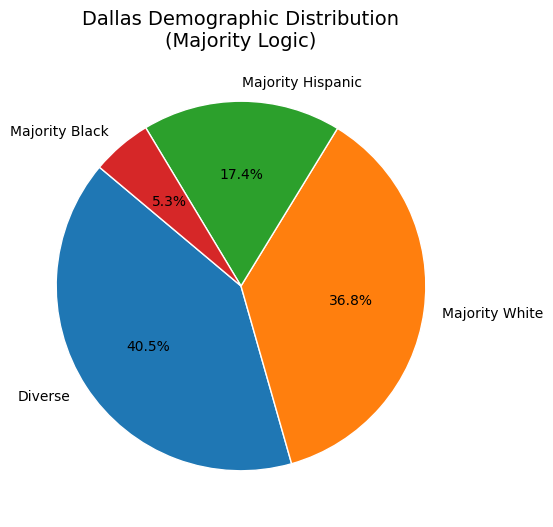

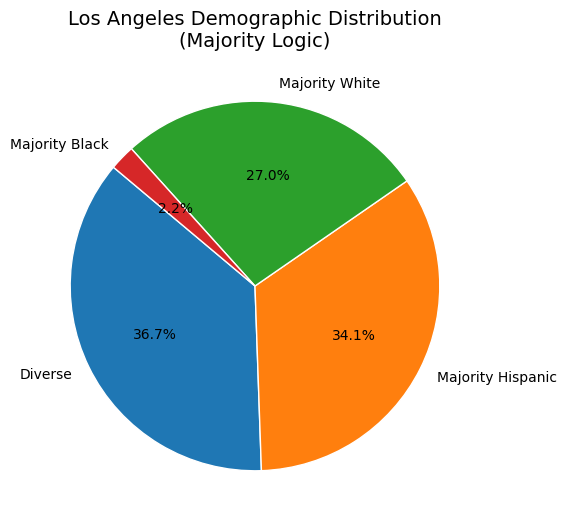

In [8]:
plot_demographic_pie(dallas_df, "Dallas")
plot_demographic_pie(los_angeles_df, "Los Angeles")


ZCTAs get categorized by majority race, if there is a race that occupies more than 50% of the population. It is worth noting that in Dallas and Los Angeles, there is a considerable amount of diverse ZCTAs as there isn't a 50% majority race. This might create an equity problem in our analysis. This observation motivates the need for modeling utilizing proportions rather than forcing categorical assignments.

#### Income Categorization through Income Quintiles

Income groups get segmented into quintiles using appropriate ZCTAs

In [9]:
def create_income_groups(df):
    """
    From a metro df, creates:
      - income_quintile (Q1_Lowest ... Q5_Highest)
      - low_income (1 if Q1 or Q2)
    """
    df_clean = df[df["median_income"] > 0].copy()

    df_clean["income_quintile"] = pd.qcut(
        df_clean["median_income"],
        q=5,
        labels=["Q1_Lowest", "Q2_Low", "Q3_Middle", "Q4_High", "Q5_Highest"]
    )

    df_clean["low_income"] = df_clean["income_quintile"].isin(
        ["Q1_Lowest", "Q2_Low"]
    ).astype(int)

    return df_clean


In [10]:
phoenix_clean     = create_income_groups(phoenix_df)
memphis_clean     = create_income_groups(memphis_df)
los_angeles_clean = create_income_groups(los_angeles_df)
dallas_clean      = create_income_groups(dallas_df)

for name, d in [("Phoenix", phoenix_clean),
                ("Memphis", memphis_clean),
                ("Los Angeles", los_angeles_clean),
                ("Dallas", dallas_clean)]:
    print(f"{name} (after income filter): {len(d)} ZCTAs")



Phoenix (after income filter): 140 ZCTAs
Memphis (after income filter): 58 ZCTAs
Los Angeles (after income filter): 248 ZCTAs
Dallas (after income filter): 188 ZCTAs


In [11]:
# Ensure 5-digit ZCTA codes in the metro data
for frame in [dallas_clean, los_angeles_clean]:
    frame["ZCTA5CE"] = (
        frame["ZCTA5CE"]
        .astype(str)
        .str.extract(r"(\d{5})", expand=False)
        .str.zfill(5)
    )


In [12]:
def get_quintile_thresholds(df, metro_name):
    incomes = df["median_income"].dropna()
    qs = incomes.quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).round(0)

    print(f"\n{metro_name} Income Quintile Thresholds:\n")
    print(f"Q1 (Lowest 20%)       : ≤ ${qs.iloc[1]:,.0f}")
    print(f"Q2 (Lower-middle)     : ${qs.iloc[1]:,.0f} – ${qs.iloc[2]:,.0f}")
    print(f"Q3 (Middle)           : ${qs.iloc[2]:,.0f} – ${qs.iloc[3]:,.0f}")
    print(f"Q4 (Upper-middle)     : ${qs.iloc[3]:,.0f} – ${qs.iloc[4]:,.0f}")
    print(f"Q5 (Highest 20%)      : ≥ ${qs.iloc[4]:,.0f}")

get_quintile_thresholds(dallas_clean, "Dallas")
get_quintile_thresholds(los_angeles_clean, "Los Angeles")



Dallas Income Quintile Thresholds:

Q1 (Lowest 20%)       : ≤ $60,709
Q2 (Lower-middle)     : $60,709 – $75,816
Q3 (Middle)           : $75,816 – $95,031
Q4 (Upper-middle)     : $95,031 – $117,194
Q5 (Highest 20%)      : ≥ $117,194

Los Angeles Income Quintile Thresholds:

Q1 (Lowest 20%)       : ≤ $72,562
Q2 (Lower-middle)     : $72,562 – $88,625
Q3 (Middle)           : $88,625 – $104,275
Q4 (Upper-middle)     : $104,275 – $127,510
Q5 (Highest 20%)      : ≥ $127,510


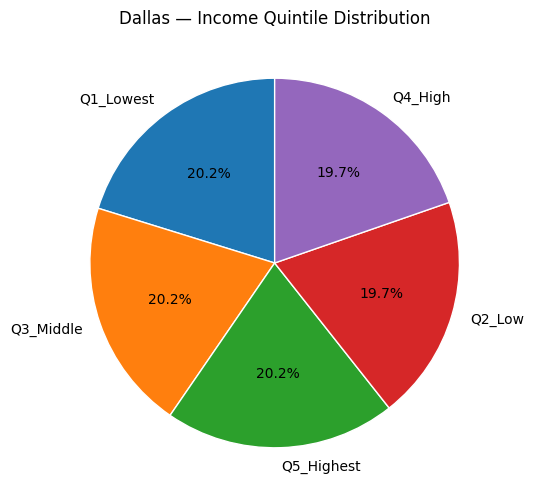

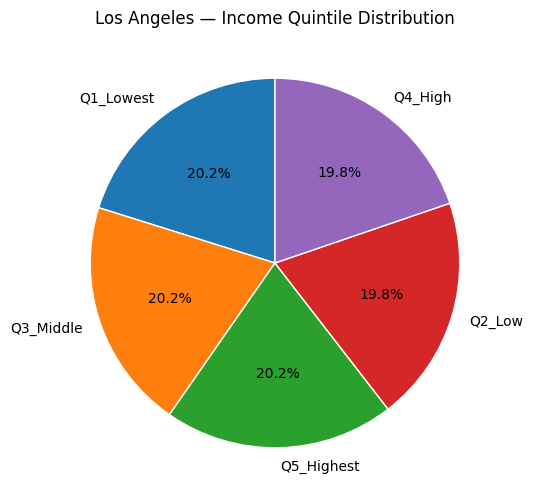

In [13]:
def plot_income_pie(df, metro_name):
    counts = df["income_quintile"].value_counts(dropna=False)

    plt.figure(figsize=(6,6))
    counts.plot(
        kind="pie",
        autopct="%1.1f%%",
        startangle=90,
        wedgeprops={"edgecolor":"white"}
    )
    plt.title(f"{metro_name} — Income Quintile Distribution")
    plt.ylabel("")
    plt.show()

for name, d in [ ("Dallas", dallas_clean),("Los Angeles", los_angeles_clean)]:
    plot_income_pie(d, name)





#### Standardization

In [14]:
def add_commute_vars(df):
    """
    Adds pct_long_commute and standardized versions of key commute vars.
    """
    df = df.copy()

    if {"pct_commute_45_59", "pct_commute_60_plus"}.issubset(df.columns):
        df["pct_long_commute"] = (
            df["pct_commute_45_59"].fillna(0) +
            df["pct_commute_60_plus"].fillna(0)
        )

    vars_to_std = ["commute_min_proxy", "pct_car", "stops_per_km2", "pct_long_commute"]
    scaler = StandardScaler()

    for var in vars_to_std:
        if var in df.columns:
            df[f"{var}_std"] = scaler.fit_transform(df[[var]])

    return df

phoenix_clean     = add_commute_vars(phoenix_clean)
memphis_clean     = add_commute_vars(memphis_clean)
los_angeles_clean = add_commute_vars(los_angeles_clean)
dallas_clean      = add_commute_vars(dallas_clean)


We standardize first so groups with bigger numeric variances will not automatically have smaller coefficients and groups with smaller variances won't show as artificially inlfated coefficients. This has the ability to create scale and sample size distortions.

### T Tests

The following t-tests are meant to compare the outcome variables: rent to income, commute length, and car availability across different demographic groups for each metro

In [23]:
def pairwise_ttests_safe(df, group_var, outcome_var,
                         equal_var=False,
                         bonferroni=False,
                         min_n=2):
    """
    Pairwise independent-samples t-tests between all groups of `group_var`
    for a single outcome variable.

    Parameters
    ----------
    df : pd.DataFrame
        Data with grouping + outcome columns.
    group_var : str
        Column name defining the groups (e.g., 'demographic_category').
    outcome_var : str
        Column name of the outcome to compare (e.g., 'rent_to_income').
    equal_var : bool, default False
        If False, uses Welch's t-test (unequal variances).
    bonferroni : bool, default False
        If True, adds Bonferroni-adjusted p-values.
    min_n : int, default 2
        Minimum number of observations required in each group.

    Returns
    -------
    pd.DataFrame
        One row per group pair, with mean difference for that outcome,
        t-statistic, p-values, and significance flag.
    """
    # Keep only needed columns and drop rows with missing outcome
    df_sub = df[[group_var, outcome_var]].dropna().copy()
    groups = df_sub[group_var].dropna().unique()
    n_comparisons = len(list(combinations(groups, 2)))
    rows = []

    for g1, g2 in combinations(groups, 2):
        d1 = df_sub[df_sub[group_var] == g1][outcome_var]
        d2 = df_sub[df_sub[group_var] == g2][outcome_var]
        n1, n2 = len(d1), len(d2)

        # Not enough ZCTAs in either group → skip with note
        if n1 < min_n or n2 < min_n:
            rows.append({
                "outcome": outcome_var,
                "Group 1": g1,
                "Group 2": g2,
                "n1": n1,
                "n2": n2,
                "Mean Diff": np.nan,
                "t-stat": np.nan,
                "p-value": np.nan,
                "adj_p": np.nan if bonferroni else None,
                "sig": "too few obs"
            })
            continue

        # t-test
        t_stat, p_val = stats.ttest_ind(d1, d2, equal_var=equal_var)

        # Optional Bonferroni adjustment
        if bonferroni:
            adj_p = min(p_val * n_comparisons, 1.0)
            p_for_sig = adj_p
        else:
            adj_p = None
            p_for_sig = p_val

        sig = (
            "***" if p_for_sig < 0.001 else
            "**" if p_for_sig < 0.01 else
            "*" if p_for_sig < 0.05 else
            "ns"
        )

        rows.append({
            "outcome": outcome_var,
            "Group 1": g1,
            "Group 2": g2,
            "n1": n1,
            "n2": n2,
            "Mean Diff": d1.mean() - d2.mean(),
            "t-stat": t_stat,
            "p-value": p_val,
            "adj_p": adj_p,
            "sig": sig
        })

    return pd.DataFrame(rows)

In [24]:
def pairwise_ttests_many(df, group_var, outcome_vars,
                         equal_var=False,
                         bonferroni=False,
                         min_n=2):
    """
    Run pairwise_ttests_safe for a list of outcome variables and stack
    results into a single DataFrame with an 'outcome' column.
    """
    frames = []
    for outcome in outcome_vars:
        res = pairwise_ttests_safe(
            df,
            group_var=group_var,
            outcome_var=outcome,
            equal_var=equal_var,
            bonferroni=bonferroni,
            min_n=min_n
        )
        frames.append(res)

    return pd.concat(frames, ignore_index=True)


In [25]:
outcomes = ["rent_to_income", "commute_min_proxy", "pct_car"]

dallas_pw = pairwise_ttests_many(
    dallas_clean,
    group_var="demographic_category",
    outcome_vars=outcomes,
    equal_var=False,
    bonferroni=True
)

print("\nDallas – Pairwise t-tests for all outcomes:")
print(dallas_pw.to_string(index=False))


Dallas – Pairwise t-tests for all outcomes:
          outcome           Group 1           Group 2  n1  n2  Mean Diff    t-stat      p-value        adj_p sig
   rent_to_income           Diverse    Majority White  74  68   0.044858  6.100017 9.804368e-09 5.882621e-08 ***
   rent_to_income           Diverse Majority Hispanic  74  33  -0.010077 -1.350976 1.801552e-01 1.000000e+00  ns
   rent_to_income           Diverse    Majority Black  74  10  -0.034935 -1.907748 8.367583e-02 5.020550e-01  ns
   rent_to_income    Majority White Majority Hispanic  68  33  -0.054935 -7.431899 7.829738e-11 4.697843e-10 ***
   rent_to_income    Majority White    Majority Black  68  10  -0.079793 -4.363857 1.229160e-03 7.374958e-03  **
   rent_to_income Majority Hispanic    Majority Black  33  10  -0.024858 -1.356341 2.029373e-01 1.000000e+00  ns
commute_min_proxy           Diverse    Majority White  75  70   0.018458  0.022941 9.817313e-01 1.000000e+00  ns
commute_min_proxy           Diverse Majority Hispan

In [26]:
# Outcomes you want to compare
outcomes = ["rent_to_income", "commute_min_proxy", "pct_car"]

# Run pairwise tests for Los Angeles
la_pw = pairwise_ttests_many(
    los_angeles_clean,
    group_var="demographic_category",
    outcome_vars=outcomes,
    equal_var=False,   # Welch t-test
    bonferroni=True,   # adjust p-values
    min_n=2            # require at least 2 ZCTAs per category
)

print("\nLos Angeles – Pairwise t-tests for all outcomes:")
print(la_pw.to_string(index=False))



Los Angeles – Pairwise t-tests for all outcomes:
          outcome           Group 1        Group 2  n1  n2  Mean Diff    t-stat      p-value        adj_p sig
   rent_to_income Majority Hispanic        Diverse  83  87   0.014552  1.969413 5.055449e-02 3.033269e-01  ns
   rent_to_income Majority Hispanic Majority Black  83   6   0.003445  0.154823 8.824357e-01 1.000000e+00  ns
   rent_to_income Majority Hispanic Majority White  83  70   0.023110  2.351518 2.040761e-02 1.224456e-01  ns
   rent_to_income           Diverse Majority Black  87   6  -0.011107 -0.497095 6.378882e-01 1.000000e+00  ns
   rent_to_income           Diverse Majority White  87  70   0.008558  0.852725 3.954961e-01 1.000000e+00  ns
   rent_to_income    Majority Black Majority White   6  70   0.019665  0.845272 4.274370e-01 1.000000e+00  ns
commute_min_proxy Majority Hispanic        Diverse  83  89   1.183549  2.081818 3.887379e-02 2.332427e-01  ns
commute_min_proxy Majority Hispanic Majority Black  83   6  -2.685911 

### Coefficient Heatmaps

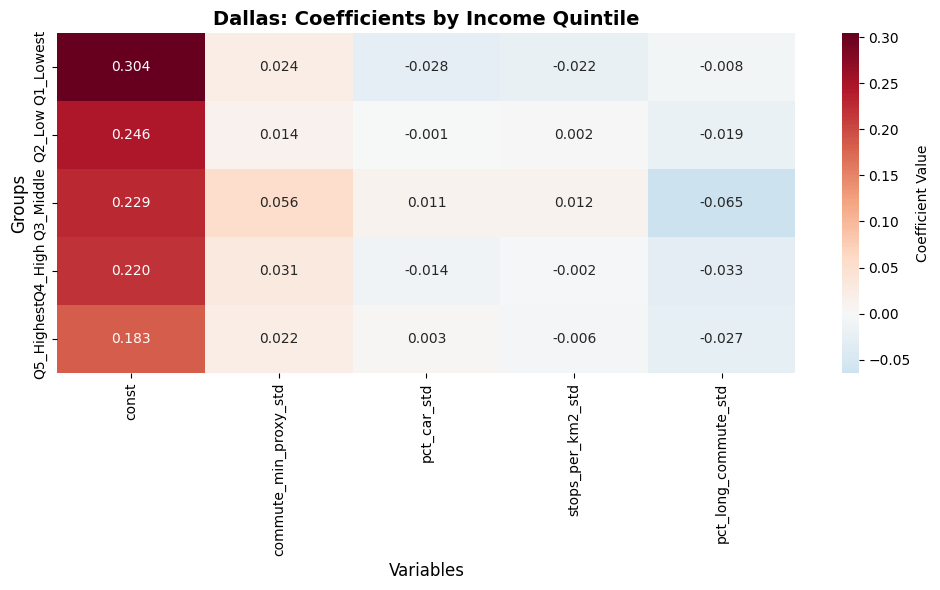

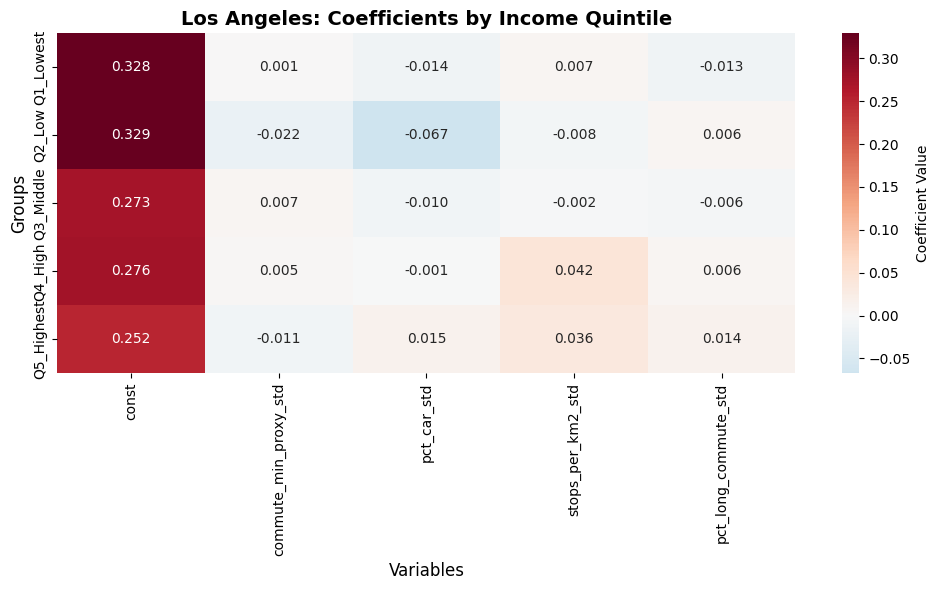

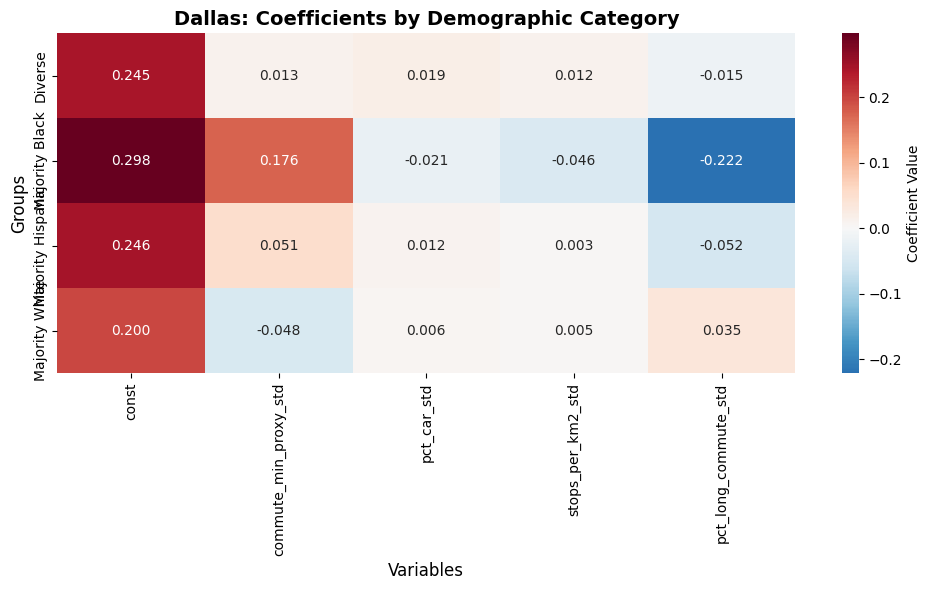

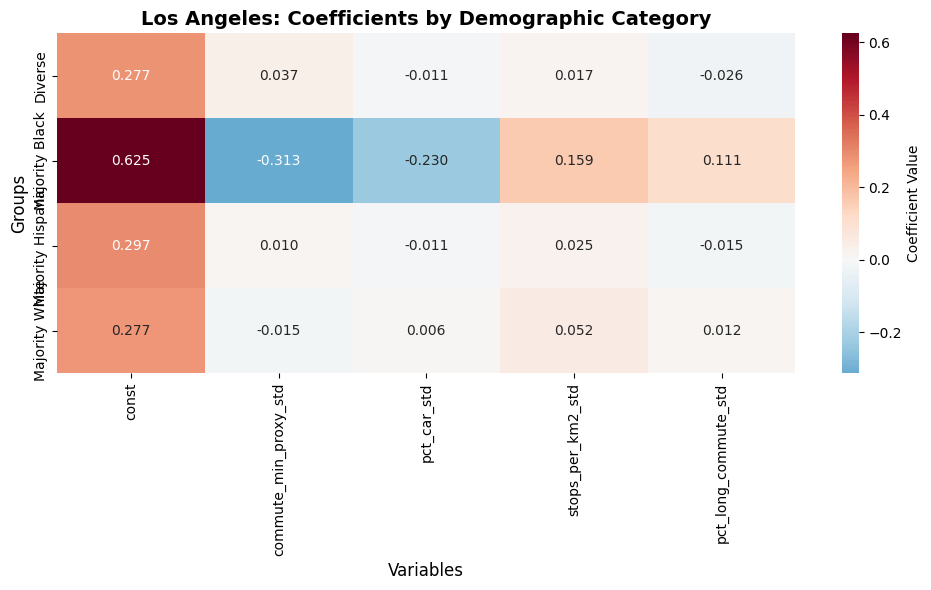

In [18]:


#Heatmap function
def create_coefficient_heatmap(models_dict, title):
    """
    Create heatmap of coefficients across stratified models
    """
    # Extract coefficients
    coef_data = {}
    for group, model_info in models_dict.items():
        if 'model' in model_info:
            coef_data[group] = model_info['model'].params
    
    if not coef_data:
        print(f"No data available for {title}")
        return
    
    coef_df = pd.DataFrame(coef_data).T
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(coef_df, annot=True, fmt='.3f', cmap='RdBu_r', center=0, 
                cbar_kws={'label': 'Coefficient Value'}, ax=ax)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Variables', fontsize=12)
    ax.set_ylabel('Groups', fontsize=12)
    plt.tight_layout()
    plt.show()

# 2) Function to build stratified models
def build_stratified_models(df, strat_var, y_var, x_vars, min_n=30):
    """
    Fit separate OLS models within each group of `strat_var`.
    Returns dict of {group_name: {'model': fitted_model}}.
    """
    models = {}
    
    # explicit observed=False to silence warning
    for group_name, group in df.groupby(strat_var, observed=False):
        data = group.dropna(subset=[y_var] + x_vars).copy()
        
        # Skip tiny groups so the regression doesn't blow up
        if len(data) < 2:
            print(f"Skipping {group_name} in {strat_var}: only {len(data)} rows")
            continue
        
        X = data[x_vars]
        X = sm.add_constant(X)      # add intercept
        y = data[y_var]

        try:
            model = sm.OLS(y, X).fit()
            models[group_name] = {"model": model}

        except Exception as e:
            print("Cant fit for [group_name}: {e}")
    return models

# 3) Choose predictors (make sure these columns exist and are already standardized)
predictors = [
    'commute_min_proxy_std',
    'pct_car_std',
    'stops_per_km2_std',
    'pct_long_commute_std'
]

# 4) Build models for Dallas & LA – income quintiles
dallas_income_models = build_stratified_models(
    dallas_clean,
    strat_var='income_quintile',
    y_var='rent_to_income',
    x_vars=predictors
)

la_income_models = build_stratified_models(
    los_angeles_clean,
    strat_var='income_quintile',
    y_var='rent_to_income',
    x_vars=predictors
)

# 5) Build models for Dallas & LA – demographic categories
dallas_demo_models = build_stratified_models(
    dallas_clean,
    strat_var='demographic_category',
    y_var='rent_to_income',
    x_vars=predictors
)

la_demo_models = build_stratified_models(
    los_angeles_clean,
    strat_var='demographic_category',
    y_var='rent_to_income',
    x_vars=predictors
)

# 6) Make the four heatmaps you need (Dallas & LA only)
create_coefficient_heatmap(dallas_income_models,
                           'Dallas: Coefficients by Income Quintile')

create_coefficient_heatmap(la_income_models,
                           'Los Angeles: Coefficients by Income Quintile')

create_coefficient_heatmap(dallas_demo_models,
                           'Dallas: Coefficients by Demographic Category')

create_coefficient_heatmap(la_demo_models,
                           'Los Angeles: Coefficients by Demographic Category')



### Baseline Analysis

The baseline model estimated for each metro is:

$$
\text{rent\_to\_income}_i 
= \beta_0 
+ \beta_1 \cdot \text{commute\_min\_proxy}_i 
+ \beta_2 \cdot \text{commute\_min\_proxy}_i^{\,2}
+ \beta_3 \cdot \text{pct\_car}_i 
+ \beta_4 \cdot \text{stops\_per\_km2}_i 
+ \beta_5 \cdot \text{total\_pop}_i
+ \varepsilon_i
$$


In [19]:
#baseline
import statsmodels.formula.api as smf

def fit_baseline_model(df, metro_name):
    """
    Baseline OLS Model:
    rent_to_income ~ commute_min_proxy + commute_min_proxy^2 + pct_car + stops_per_km2 + total_pop
    """
    model_df = df[['rent_to_income', 'commute_min_proxy', 'pct_car', 
                   'stops_per_km2', 'total_pop']].dropna()

    # quadratic commute term
    model_df['commute_sq'] = model_df['commute_min_proxy'] ** 2
    
    # fit model
    formula = 'rent_to_income ~ commute_min_proxy + commute_sq + pct_car + stops_per_km2 + total_pop'
    model = smf.ols(formula, data=model_df).fit()

    print(f"\n{'='*90}")
    print(f"{metro_name} — Baseline OLS Model")
    print(f"{'='*90}")
    display(model.summary())
    
    return model, model_df

# Run for Dallas & LA
dallas_baseline, dallas_model_df = fit_baseline_model(dallas_clean, 'Dallas')
la_baseline,     la_model_df     = fit_baseline_model(los_angeles_clean, 'Los Angeles')



Dallas — Baseline OLS Model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rent_to_income   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     5.101
Date:                Sat, 22 Nov 2025   Prob (F-statistic):           0.000213
Time:                        01:16:15   Log-Likelihood:                 306.75
No. Observations:                 185   AIC:                            -601.5
Df Residuals:                     179   BIC:                            -582.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1081      0.118     -0.914      0.362      -0.341       0.125
commute_min_proxy     0.0077      0.008      1.030      0.305      -0.007       0.023
commute_sq           -0.0001      0.000     -1.256      0.211      -0.000    8.47e-05
pct_car               0.0028      0.001      4.283      0.000       0.001       0.004
stops_per_km2         0.0026      0.001      3.058      0.003       0.001       0.004
total_pop          2.086e-07   2.01e-07      1.038      0.300   -1.88e-07    6.05e-07
==============================================================================
Omnibus:                       54.293   Durbin-Watson:                   1.671
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              117.182
Skew:                           1.342   Prob(JB):                     3.58e-26
Kurtosis:                       5.827   Cond. No.                     1.25e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


Los Angeles — Baseline OLS Model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rent_to_income   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     21.30
Date:                Sat, 22 Nov 2025   Prob (F-statistic):           1.29e-17
Time:                        01:16:15   Log-Likelihood:                 405.13
No. Observations:                 246   AIC:                            -798.3
Df Residuals:                     240   BIC:                            -777.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3067      0.096      3.202      0.002       0.118       0.495
commute_min_proxy    -0.0035      0.006     -0.576      0.565      -0.015       0.008
commute_sq         4.981e-05   9.24e-05      0.539      0.590      -0.000       0.000
pct_car              -0.0001      0.000     -0.254      0.800      -0.001       0.001
stops_per_km2         0.0044      0.001      7.719      0.000       0.003       0.006
total_pop          5.057e-07   1.68e-07      3.008      0.003    1.75e-07    8.37e-07
==============================================================================
Omnibus:                      105.251   Durbin-Watson:                   1.694
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              634.608
Skew:                           1.585   Prob(JB):                    1.57e-138
Kurtosis:                      10.202   Cond. No.                     1.27e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Pooled Analysis

The pooled analysis model is:


$$
\begin{aligned}
\text{rent\_to\_income}_i
&= \beta_0
  + \beta_1 \,\text{commute\_min\_proxy}_i
  + \beta_2 \,\text{commute\_min\_proxy}_i^{2}
  + \beta_3 \,\text{low\_income}_i \\
&\quad + \beta_4 \,\bigl(\text{commute\_min\_proxy}_i \times \text{low\_income}_i\bigr)
  + \beta_5 \,\text{stops\_per\_km2}_i
  + \beta_6 \,\text{pct\_car}_i
  + \beta_7 \,\text{total\_pop}_i \\
&\quad + \gamma_{\text{LA}}\, \mathbb{1}\{\text{metro}_i = \text{Los Angeles}\}
  + \varepsilon_i \, .
\end{aligned}
$$



In [21]:
# Combine datasets for pooled analysis
dallas_clean = dallas_clean.copy()
los_angeles_clean = los_angeles_clean.copy()

dallas_clean["metro"] = "Dallas"
los_angeles_clean["metro"] = "Los Angeles"

pooled_df = pd.concat([dallas_clean, los_angeles_clean], ignore_index=True)

# Add squared commute term *before* subsetting
pooled_df["commute_sq"] = pooled_df["commute_min_proxy"] ** 2

# Prepare data (now include commute_sq in the column list)
pooled_model_df = pooled_df[
    [
        "rent_to_income",
        "commute_min_proxy",
        "commute_sq",
        "low_income",
        "stops_per_km2",
        "pct_car",
        "total_pop",
        "metro",
    ]
].dropna()

# Create interaction term
pooled_model_df["commute_x_lowincome"] = (
    pooled_model_df["commute_min_proxy"] * pooled_model_df["low_income"]
)

# Fit model with metro controls
formula = """
rent_to_income ~ commute_min_proxy + commute_sq +
                 low_income + commute_x_lowincome +
                 stops_per_km2 + pct_car + total_pop + C(metro)
"""

pooled_model = smf.ols(formula=formula, data=pooled_model_df).fit()

print("\n" + "=" * 90)
print("Pooled Interaction Model (Dallas + Los Angeles)")
print("=" * 90)
display(pooled_model.summary())

# F-test for interaction
from statsmodels.stats.anova import anova_lm

print("\n" + "=" * 90)
print("F-test for Interaction Term (commute × low_income)")
print("=" * 90)

formula_restricted = """
rent_to_income ~ commute_min_proxy + commute_sq +
                  low_income + stops_per_km2 + pct_car + total_pop + C(metro)
"""

pooled_restricted = smf.ols(formula=formula_restricted, data=pooled_model_df).fit()

anova_results = anova_lm(pooled_restricted, pooled_model)
display(anova_results)




Pooled Interaction Model (Dallas + Los Angeles)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rent_to_income   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     47.37
Date:                Sat, 22 Nov 2025   Prob (F-statistic):           3.28e-54
Time:                        01:20:58   Log-Likelihood:                 754.29
No. Observations:                 431   AIC:                            -1491.
Df Residuals:                     422   BIC:                            -1454.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.1949      0.065      2.976      0.003       0.066       0.324
C(metro)[T.Los Angeles]     0.0323      0.005      6.058      0.000       0.022       0.043
commute_min_proxy           0.0040      0.004      0.965      0.335      -0.004       0.012
commute_sq              -5.446e-05   6.52e-05     -0.835      0.404      -0.000    7.37e-05
low_income                  0.1085      0.032      3.419      0.001       0.046       0.171
commute_x_lowincome        -0.0017      0.001     -1.741      0.082      -0.004       0.000
stops_per_km2               0.0020      0.000      4.265      0.000       0.001       0.003
pct_car                    -0.0008      0.000     -2.368      0.018      -0.001      -0.000
total_pop                2.498e-07   1.18e-07      2.117      0.035    1.79e-08    4.82e-07
==============================================================================
Omnibus:                      128.502   Durbin-Watson:                   1.711
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              502.546
Skew:                           1.284   Prob(JB):                    7.47e-110
Kurtosis:                       7.625   Cond. No.                     1.23e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


F-test for Interaction Term (commute × low_income)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,423.0,0.767347,0.0,NaN,NaN,NaN
1,422.0,0.761878,1.0,0.00547,3.029578,0.082488


Here, we estimate a pooled model across Dallas and Los Angeles to test whether the commute affordability relationship differs between income levels. ANOVA is then conducted comparing a restricted model and an interaction model. Based on ANOVA results, the interaction is slightly significant, further suggesting that commute lengths affect rent burden differently depending on neighborhood income level. Instead of using basic pvalues, we utilize Bonferroni p-values to prevent false positives. Since the effect is borderline, analysis would benefit from more controls or more metros.

In [22]:
def fit_stratified_models(df, strata_var, metro_name):
    """
    Fit separate OLS regressions per group (no n≥30 rule).
    """
    results = {}
    
    for grp in df[strata_var].dropna().unique():
        subset = df[df[strata_var] == grp]
        model_data = subset[['rent_to_income', 'commute_min_proxy', 'pct_car', 
                             'stops_per_km2', 'total_pop']].dropna()
        
        if len(model_data) < 5:
            print(f"Skipping {grp} (too few obs, n={len(model_data)})")
            continue
        
        formula = 'rent_to_income ~ commute_min_proxy + pct_car + stops_per_km2 + total_pop'
        model = smf.ols(formula, data=model_data).fit()
        
        results[grp] = {
            'model': model,
            'n': len(model_data),
            'commute_coef': model.params['commute_min_proxy'],
            'pvalue': model.pvalues['commute_min_proxy'],
            'r2': model.rsquared,
            'adj_r2': model.rsquared_adj
        }
    
    # summary table
    summary_df = pd.DataFrame(results).T
    print(f"\n{'='*90}")
    print(f"{metro_name} — Stratified OLS by {strata_var}")
    print(f"{'='*90}")
    display(summary_df[['n','r2','adj_r2','commute_coef','pvalue']])
    
    return results

# Run stratified models for both metros
dallas_income_models = fit_stratified_models(dallas_clean, 'income_quintile', 'Dallas')
la_income_models     = fit_stratified_models(los_angeles_clean, 'income_quintile', 'Los Angeles')

dallas_demo_models = fit_stratified_models(dallas_clean, 'demographic_category', 'Dallas')
la_demo_models     = fit_stratified_models(los_angeles_clean, 'demographic_category', 'Los Angeles')



Dallas — Stratified OLS by income_quintile


,n,r2,adj_r2,commute_coef,pvalue
Q3_Middle,38,0.144387,0.040676,-0.002084,0.094198
Q5_Highest,36,0.069435,-0.050638,-0.000997,0.42241
Q4_High,36,0.096249,-0.020364,-0.001026,0.568095
Q2_Low,37,0.208311,0.10935,-0.000392,0.729293
Q1_Lowest,38,0.165999,0.064908,0.003474,0.093759



Los Angeles — Stratified OLS by income_quintile


,n,r2,adj_r2,commute_coef,pvalue
Q1_Lowest,49,0.268083,0.201545,-0.002585,0.281457
Q2_Low,49,0.717079,0.691359,-0.004619,0.005204
Q4_High,48,0.415628,0.361267,0.00309,0.039084
Q3_Middle,50,0.045082,-0.0398,0.000358,0.807351
Q5_Highest,50,0.113274,0.034453,0.001888,0.375815



Dallas — Stratified OLS by demographic_category


,n,r2,adj_r2,commute_coef,pvalue
Diverse,74,0.082543,0.029358,0.000175,0.898094
Majority White,68,0.149201,0.095182,-0.003026,0.007294
Majority Hispanic,33,0.191889,0.076444,-0.000092,0.941652
Majority Black,10,0.129714,-0.566515,-0.003429,0.558583



Los Angeles — Stratified OLS by demographic_category


,n,r2,adj_r2,commute_coef,pvalue
Majority Hispanic,83,0.44852,0.420239,-0.000972,0.432026
Diverse,87,0.395322,0.365825,0.002519,0.07608
Majority Black,6,0.266934,-2.66533,-0.014899,0.744342
Majority White,70,0.247074,0.20074,-0.000645,0.801399


Although focusing on the majority offers a birds eye view of feature interaction and significance, it is very possible to unintentionally leave out non majority tracts especially with a cut off of threshold. The limitation of the stratified model is we might lose insights on small populations to the diverse category. Taking a look at LA, the population has a majority Hispanic and Majority White plurality within the ZCCTAs. By focusing on these sole majorities, we lose track of the responses from other races.

Stratified models indicate that each metros affordability- commute tradeoff penalizes different groups, meaning that we probably shouldn't run a pooled model. <br>
Other findings indicate:<br>
* In DFW commute pressure affects where racial diversity is low and incomes are more mixed
* Commute coefficients grow stronger (more positive or less negative) for lower income quintiles
* In DFW the structural lack of majority Black and Asian neighborhoods might create an equity problem in the study
* In Las Angeles, commute pressure is high in Hispanic communities but there is a high amount of Hispanic share in the Diverse categories
* Like Dallas, some racial groups don't inherit the majority ZCTA domination (Blacks and Asians)
* For LA, commute pressure is higher in majority Hispanic communities
* In LA, the middle quintiles bear significant commute-affordability pressure- possibly pushing workers out <br>
Some of these disparities aren't just statistical, some are spatial. For diverse metros like Los Angeles and Dallas,we solve the equity problem by offering a different representation solution: Cluster Grouping with a Spatial Story.


### How does this work?

We implement this strategy to deeply explore ZCTA racial composition. Clusters with race proprtions paint a better story about who has tranit rich amenities, who has high rent burden, who has low rent to income etc. By adding spatial layers to the list, we answer the question of where- adding more understanding about the differences behind inequities and how typology takes part in influencing such changes. <br>
We use these clusters to establish pooled models with indicators and interactions. This effiently utilizes all observations first and then tests whether the commute affordability slope differs by cluster/ racial group. <br>
*By introducing Geopandas and spatial clustering maps we can effectively show where the bad trade-offs  and inequities concentrate while proving that they exist.*